# Football Forecasting

Football is ubiquitous.The main objective of this project is to forecast football outcomes.... more flavor. 

We recreate the proposals of [Google](https://github.com/GoogleCloudPlatform/ipython-soccer-predictions) and [Goldman Sachs](http://www.goldmansachs.com/our-thinking/macroeconomic-insights/euro-cup-2016/) to tackle this task. We implemented both algortihms to predict the results of Comebol qualifiers and estimate the probability that Peru qualifies to the World Cup. Then, we propose a different approach in order to improve the accuaracy of the model. 


## Data
The database contains information at match level from seasons 2011/12, 2012/13 and 2013/14 for three leagues and the 2014 World Cup. The leagues included are:
* MLS (USA)
* Premier League (England)
* La Liga (Spain)
 
Attributes used for prediction consider the average of the last six games of each team (home and away).

In [2]:
import pandas as pd

# Import main dataset
parser2 = lambda date: pd.datetime.strptime(date, '%Y-%m-%d %H:%M:%f')
raw_data = pd.read_csv('./data/raw_data_ready.csv', index_col=0, header=0, 
                       parse_dates=['timestamp'], date_parser=parser2, 
                       encoding='utf-8')

# Import Comebol dataset
test_peru = pd.read_csv('./data/comebol_complete.csv', index_col=0, header=0)

# Partition the main dataset and the club data. We're only going to 
# train our model using club data.
club_data = raw_data.loc[raw_data['competitionid'] != 4]

    
# Generate a table with goals and points using club data.
points = club_data.replace({'points': {0: 'lose', 1: 'tie', 3: 'win'}})['points']
goals_points = pd.crosstab(club_data['goals'], points)

print('Goals and points:\n{0}'.format(goals_points))


Goals and points:
points  lose  tie  win
goals                 
0        727  267    0
1        477  394  320
2        131  205  500
3         21   40  314
4          2    6  148
5          0    2   65
6          0    0   12
7          0    0    6
8          0    0    1


## Google algorithm

Google implements a lasso logistic regression. Their most important weakness is the omission of tie predictions, which accounts to near 25% of the outcomes in the dataset.

### Training
The database is split into train and test with a 3 to 2 ratio. The model will be trained using the standardized train dataset. The target variable is a dummy that has a value equal to 1 if the team won and 0 if they lost. As mentioned before, ties are excluded from the analysis. The regularization parameter was selected through cross validation.

In [4]:
import code.wc_pred.world_cup as world_cup
import code.wc_pred.match_stats as match_stats

# Drop draws
train = club_data.loc[club_data['points'] != 1] 

# Train model
(model, test) = world_cup.train_model(train, match_stats.get_non_feature_columns())

# We print the Pseudo-Rsquared and the odds ratio increase generated by
# each attribute.
print('Rsquared: {0:.3f}'.format(model.prsquared))
print('Highest parameters from each category:')
world_cup.print_params(model, 5)

Rsquared: 0.153
Highest parameters from each category:
Positive features
is_home                  0.664457
pass_70                  0.394515
opp_op_expected_goals    0.187115
opp_op_pass_80           0.167198
opp_bad_passes           0.128878
dtype: float64

Dropped features
op_fouls          0.0
op_bad_passes     0.0
pass_ratio        0.0
corners           0.0
shots_op_ratio    0.0
dtype: float64

Negative features
opp_pass_70         -0.282905
op_expected_goals   -0.157622
op_pass_80          -0.143247
bad_passes          -0.114165
opp_avg_goals       -0.074598
dtype: float64


Without much surprise, the most important feature that determines the outcome of a match is the locality of the team. The second most important is the amount of passes done in the top 30% of the field.

### Forecasting

Predictions are made using the test set, which contains information that the model has not seen before. The logistic model returns the probability that the outcome variable will be 1. We have selected a threshold of 0.5 to decide if the outcome is 1 or 0.  

In [8]:
# Predict results for the test dataset.
results = world_cup.predict_model(model, test, 
                                  match_stats.get_non_feature_columns())

# The threshold selected for a win is 50 percent points.
threshold = 0.5

# Extract the predictions in a nice format.
predictions = world_cup.extract_predictions(
        results.copy(), results['predicted'], threshold*100)
    
# Print True Positives and False Positives using the 0.5 threshold (50 percent points).
correct = predictions[(predictions['predicted'] > threshold*100) & 
                      (predictions['points'] == 3)][:5]
incorrect = predictions[(predictions['predicted'] > threshold*100) &
                        (predictions['points'] < 3)][:5]
print('\nCorrect predictions:\n{0}'.format(correct))
print('\nIncorrect predictions:\n{0}'.format(incorrect))


Correct predictions:
             team_name op_team_name  predicted            expected  \
37           Barcelona   Villarreal  80.802775           Barcelona   
41       Real Sociedad   Real Betis  52.220781       Real Sociedad   
48  Atlético de Madrid       Getafe  74.321181  Atlético de Madrid   
59          Real Betis      Levante  55.049534          Real Betis   
60          Villarreal       Getafe  58.243117          Villarreal   

                winner  points  
37           Barcelona       3  
41       Real Sociedad       3  
48  Atlético de Madrid       3  
59          Real Betis       3  
60          Villarreal       3  

Incorrect predictions:
               team_name          op_team_name  predicted  \
8        Colorado Rapids             FC Dallas  51.103486   
12  Sporting Kansas City           D.C. United  54.258796   
14        Houston Dynamo  San Jose Earthquakes  51.835156   
21    New York Red Bulls            Toronto FC  52.312388   
24               Sevilla      

### Validation

Google validates their predictions using the Area Under the Curve (AUC) of a Reciever Operator Curve (ROC). This metric shows how better their predictions were compared to random chance. A value AUC of 1 implies that the model prerfectly predicts the outcome, while a value lower than 0.5 suggests that the model is not better than random chance. 

In this case, google selects the threshold based in the percentage of wins of the dataset.

Proportion of wins in club data: 0.375
Prediction metrics:
(3) Threshold: 0.577 | Lift: 1.460 Auc: 0.757
    Base: 0.375 Acc: 0.673 P(1|t): 0.730 P(0|f): 0.639
    Fp/Fn/Tp/Tn p/n/c: 102/227/276/401 503/503/1006


0.5773722051858738

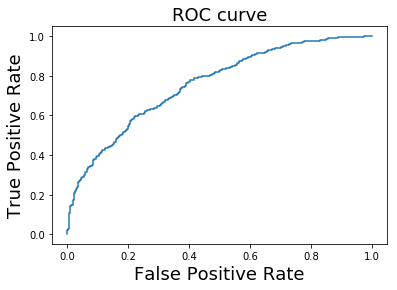

In [11]:
import matplotlib.pyplot as plt

# Compute a baseline, which is the percentage of overall outcomes 
# are actually wins (remember in soccer we can have draws too).
baseline = (sum([yval == 3 for yval in club_data['points']]) * 1.0 / len(club_data))
y = [yval == 3 for yval in test['points']]
print('Proportion of wins in club data: {0:.3f}'.format(baseline))

print('Prediction metrics:')
world_cup.validate(3, y, results['predicted'], baseline, 
                   compute_auc=True, quiet=False)
#plt.close()

### Improve the prediction



### Comebol predictions

In [14]:
results_peru = world_cup.predict_model(model, test_peru, 
                                       match_stats.get_non_feature_columns())

pred_peru = world_cup.extract_predictions(results_peru, 
                                          results_peru['predicted'], 50)
print('Peru predictions:\n{0}'.format(pred_peru))